In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from skimage.color import  rgb2gray, lab2rgb, rgb2lab

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
# from keras.layers import Activation, Dense, Dropout, Flatten

from keras.optimizers import Adam
from skimage.transform import resize
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import Input
from keras.models import  Model

from keras.optimizers import Adam


# Data

### Loading datasets

In [5]:
ab = np.load('/kaggle/input/portret-dataset/ab_256_5000.npy')
L = np.load('/kaggle/input/portret-dataset/L_256_5000.npy')

In [6]:
print("ab shape:",ab.shape)
print("L shape:",L.shape)

ab shape: (5000, 256, 256, 2)
L shape: (5000, 256, 256, 1)


## Splitting data into train and test data

In [7]:
L_train, L_test, ab_train, ab_test = train_test_split(L, ab, test_size=0.2, random_state=54)
L_test, L_validation, ab_test, ab_validation = train_test_split(L_test, ab_test, test_size=0.2, random_state=54)

In [8]:
print(L_train.shape)
print(L_test.shape)
print(L_validation.shape)

(4000, 256, 256, 1)
(800, 256, 256, 1)
(200, 256, 256, 1)


# CNN with  Inception-ResNet-v2 model

In [9]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Input
from keras.layers import RepeatVector, Reshape,  concatenate, BatchNormalization
from keras.models import  Model
import keras

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from skimage import color

In [10]:
X = L_train
y = ab_train / 128

# Inception model

In [11]:
inception = InceptionResNetV2(include_top=True, weights='imagenet')

225209952/225209952 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [12]:
x_res = np.empty((len(X),299,299,3), 'float32')
img_res = np.empty((299,299,3), 'float32')
for i in range(len(X)):
  img = (X[i])
  img = cv2.resize(img,(299,299))
  img = img.reshape(299,299)
  img_res[:,:,0] = img
  img_res[:,:,1] = img
  img_res[:,:,2] = img
  x_res[i] = img_res

In [13]:
res_out = inception.predict(x_res)

  2/125 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step  

I0000 00:00:1714075096.058775      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step


## Definition of the model

In [14]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = BatchNormalization()(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)




#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input)
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)



#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = BatchNormalization()(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)



# Models

Model 1

In [15]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [16]:
opt = keras.optimizers.Adam(learning_rate=0.005)
model1 = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model1.compile(optimizer=opt, loss=SSIMLoss)

In [17]:
model1.fit([X,res_out],
         y,
         epochs = 50)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - loss: 0.9734
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.9458
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.9731
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.7607
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.5998
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.6074
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.6064
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.5766
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.5561
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.5493
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.5359
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.5407
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.5339
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - loss: 0.5602
Epoch 15/50
125

Model 2

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model2 = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model2.compile(optimizer=opt, loss='mean_squared_error')

In [19]:
model2.fit([X,res_out],
         y,
         epochs = 50)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 162ms/step - loss: 0.0102
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0095
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0095
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0095
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0091
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0095
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0093
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0093
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0092
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0094
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0092
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0091
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0091
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0092
Epoch 15/50
125

Model 3

In [20]:
opt = keras.optimizers.Adagrad(learning_rate=0.005)
model3 = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model3.compile(optimizer=opt, loss='mean_squared_error')

In [21]:
model3.fit([X,res_out],
         y,
         epochs = 50)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - loss: 0.0071
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0067
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - loss: 0.0069
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0068
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0068
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0067
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0068
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0068
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0068
Epoch 16/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0068
Epoch 17/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0067
Epoch 18/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0071
Epoch 19/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0070
Epoch 20/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 0.0068
Epoch 22/

## Prediction

In [22]:
x_res_test = np.empty((len(L_test),299,299,3), 'float32')
img_res = np.empty((299,299,3), 'float32')
for i in range(len(L_test)):
  img = (L_test[i]).reshape(256,256)
  img = cv2.resize(img,(299,299))
  img = img.reshape(299,299)
  img_res[:,:,0] = img
  img_res[:,:,1] = img
  img_res[:,:,2] = img
  x_res[i] = img_res

In [23]:
res_out_test = inception.predict(x_res_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step


In [24]:
output1 = model1.predict([L_test, res_out_test])
output2 = model2.predict([L_test, res_out_test])
output3 = model3.predict([L_test, res_out_test])

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


# Testing

In [25]:
Lab_pred_1 = np.concatenate((L_test, output1 * 128), axis=-1)
RGB_pred_1 = color.lab2rgb(Lab_pred_1)

Lab_pred_2 = np.concatenate((L_test, output2 * 128 ), axis=-1)
RGB_pred_2 = color.lab2rgb(Lab_pred_2)

Lab_pred_3 = np.concatenate((L_test, output3 * 128), axis=-1)
RGB_pred_3 = color.lab2rgb(Lab_pred_3)

In [26]:
Lab = np.concatenate((L_test, ab_test), axis=-1)
RGB = color.lab2rgb(Lab)

# Results

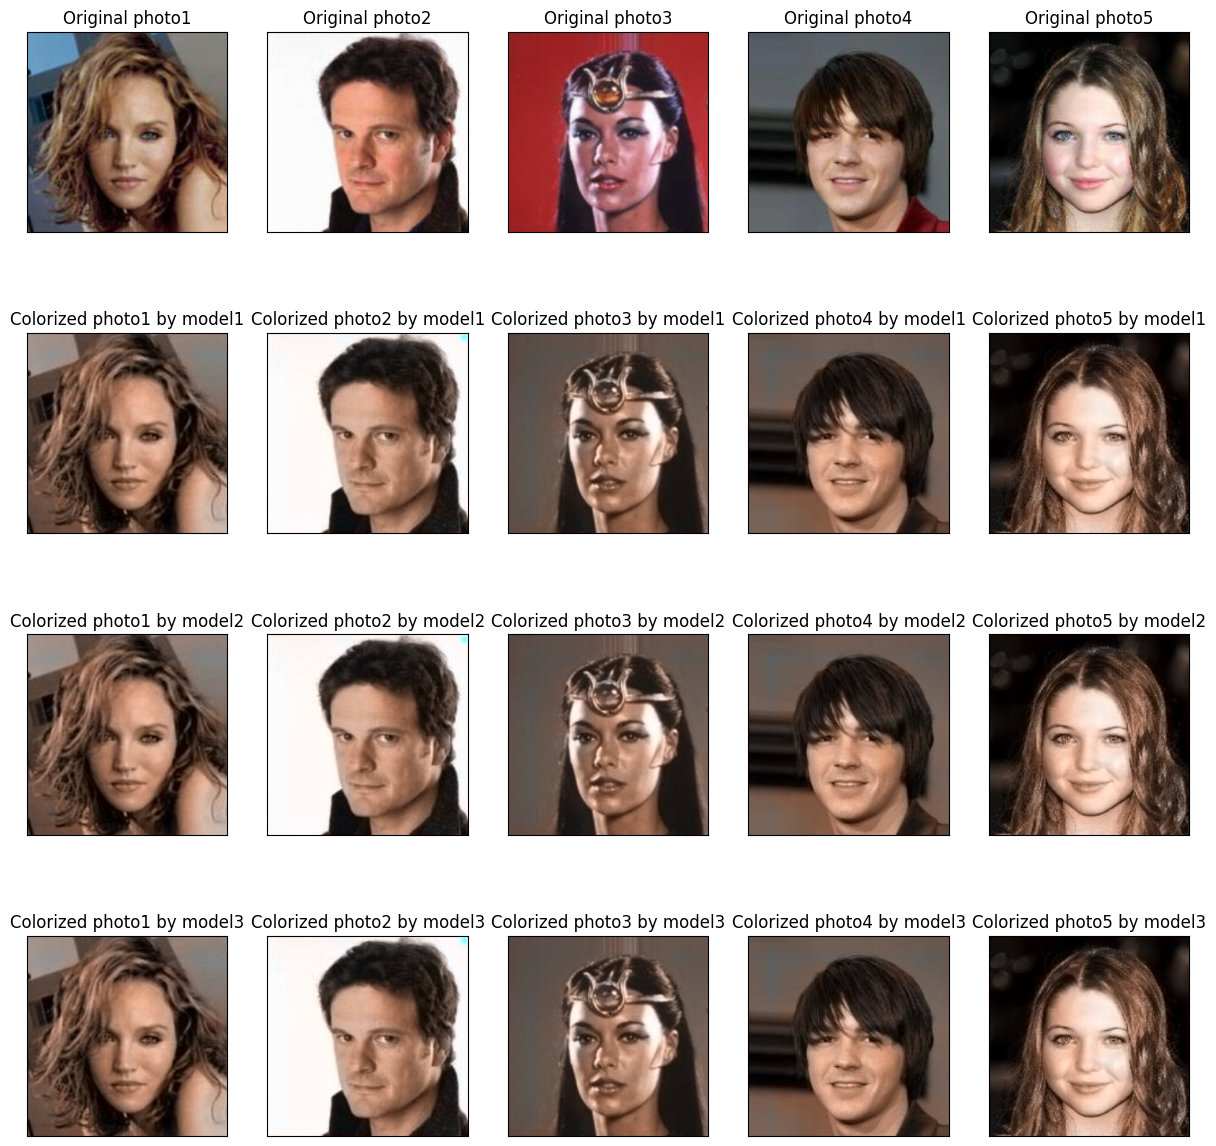

In [35]:
shift_image = 20
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(4, 5, i + 1)
    plt.imshow(RGB[i + shift_image])
    # plt.axis('off')
    plt.title('Original photo{}'.format(i+1))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 5, i + 5 +1)
    plt.imshow(RGB_pred_1[i + shift_image])
    plt.title('Colorized photo{} by model1'.format(i+1))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4, 5, i + 10 +1)
    plt.imshow(RGB_pred_1[i + shift_image])
    plt.title('Colorized photo{} by model2'.format(i+1))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(4, 5, i + 15 +1)
    plt.imshow(RGB_pred_1[i + shift_image])
    plt.title('Colorized photo{} by model3'.format(i+1))
    plt.xticks([])
    plt.yticks([])
plt.show()

### Model 1 results

In [28]:
# plt.figure(figsize=(15, 15))
# for i in range(10):
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(RGB[i + shift_image])
#     # plt.axis('off')
#     plt.title('Original{}'.format(i + 1))
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(2, 5, i + 5 + 1)
#     plt.imshow(RGB_pred_1[i + shift_image])
#     # plt.axis('off')
#     plt.title('Colorized{}'.format(i + 1))
#     plt.xticks([])
#     plt.yticks([])

# plt.show()

### Model 2 results

In [29]:
# plt.figure(figsize=(15, 15))
# for i in range(5):
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(RGB[i + shift_image])
#     # plt.axis('off')
#     plt.title('Original{}'.format(i + 1))
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(2, 5, i + 5 +1)
#     plt.imshow(RGB_pred_2[i + shift_image])
#     # plt.axis('off')
#     plt.title('Colorized{}'.format(i+1))
#     plt.xticks([])
#     plt.yticks([])

# plt.show()

### Model 3 results

In [30]:
# plt.figure(figsize=(15, 15))
# for i in range(10):
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(RGB[i + shift_image])
#     # plt.axis('off')
#     plt.title('Original{}'.format(i + 1))
#     plt.xticks([])
#     plt.yticks([])

#     plt.subplot(2, 5, i + 5 + 1)
#     plt.imshow(RGB_pred_3[i + shift_image])
#     # plt.axis('off')
#     plt.title('Colorized{}'.format(i + 1))
#     plt.xticks([])
#     plt.yticks([])

# plt.show()